# TP classification de sons à rendre

Tom Bevan (tom.bevan@etu.unice.fr)
Vinh Faucher (vinh.faucher@etu.unice.fr)

Polytech SI3 - SSII - 2021-22

# Données

Nous avons choisi 4 mots : gauche, droite, milieu, bas.
Pour chaque mot, nous avons au minimum 31 enregistrements différents.
Nous avons dû faire un prétraitement, afin notamment de convertir les fichiers en wav et pour certains de les découper.

In [1]:
#les imports nécessaires pour la suite
import matplotlib.pyplot as plt
import numpy as np 
import librosa
import librosa.display
import IPython.display as ipd
import glob

In [2]:
import sklearn
print(sklearn.__version__)

1.0.2


In [3]:
# une fonction pour dessiner chronogramme, spectre et spectrogramme
def plotCSS(signal, te):
    fe = 1/te
    n = len(signal)
    t = np.linspace(0, n*te, n,endpoint=False)
    tf = np.fft.rfftfreq(n, te)
    # afficher chronogramme, spectre et spectrogramme
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 5))
    # chronogramme
    ax1.plot(t, signal)
    ax1.set_xlabel('temps (s)')
    ax1.set_ylabel('amplitude')
    ax1.set_title("chronogramme")
    #spectre
    ax2.plot(tf,np.abs(np.fft.rfft(signal)))
    ax2.set_xlabel('fréquence (Hz)')
    ax2.set_ylabel('module de la TF')
    ax2.set_title("spectre")
    #spectrogramme
    S = np.abs(librosa.stft(signal))
    Sdb = librosa.amplitude_to_db(abs(S))
    librosa.display.specshow(Sdb, sr=fe, x_axis='time', y_axis='hz')
    ax3.set_xlabel('temps (s)')
    ax3.set_ylabel('fréquence (Hz)')
    ax3.set_title("spectrogramme")
    plt.show()  

## Les données
On va utiliser le jeu de données <a href="https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html">"speech commands"</a> que vous devez <a href="http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz">télécharger</a>.

In [64]:
basedir=r"D:\Perso\Bibliothèque\Documents\Polytech Nice\S6\SSII\TD\TD4\Sons"
# à adapter à votre chemin de sons
#attention, sous windows, il faut changer en "C:\\Users\\monNom\\monCoursPrefere\\"
classes = ["cat", "dog", "down"] #vous pouvez modifier ou ajouter d'autres classes du jeu de données

In [65]:
for cl in classes:
    listSons = glob.glob(basedir+ '\\'+cl+"/*.wav")
    print(len(listSons), "sons de la classe ", cl)

1733 sons de la classe  cat
1746 sons de la classe  dog
2359 sons de la classe  down


### On commence avec un seul son (au choix)
Charger le son, afficher le et écoutez le. A quelle fréquence est-il échantillonné ?

In [66]:
y, sr = librosa.load(listSons[0])

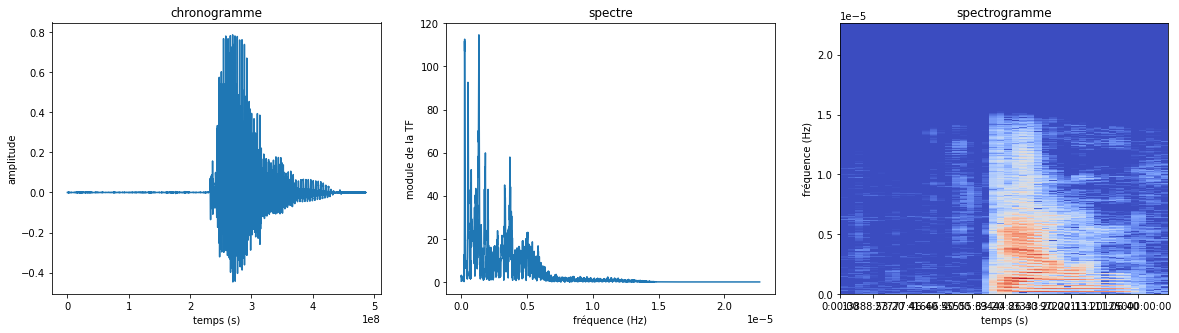

In [67]:
plotCSS(y,sr)

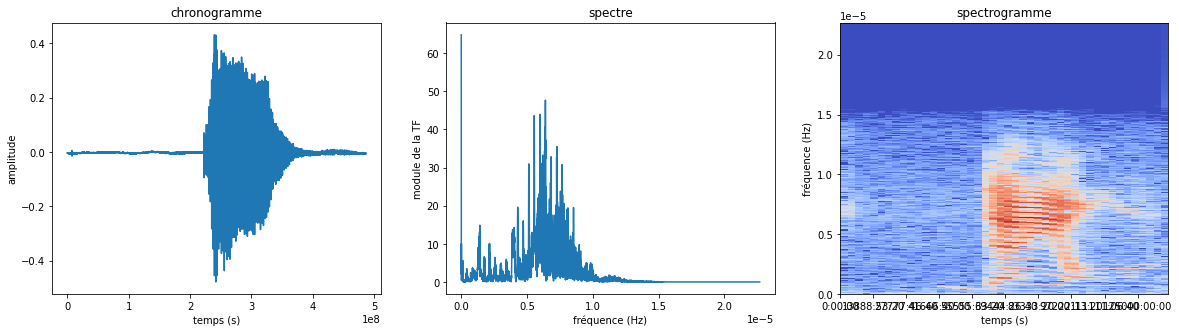

In [68]:
y, sr = librosa.load(listSons[1])
plotCSS(y,sr)

In [69]:
# écoutons 
ipd.Audio(y,rate=sr,autoplay=True)

### Calcul des MFCCs du son

In [70]:
mfccFeatures = librosa.feature.mfcc(y,sr,n_mfcc=13)

In [71]:
mfccFeatures.shape

(13, 44)

In [72]:
len(y)

22050

In [73]:
print("avec les MFCCs, on peut décrire un son par ", mfccFeatures.shape[0]*mfccFeatures.shape[1], " valeurs au lieu de ", len(y))

avec les MFCCs, on peut décrire un son par  572  valeurs au lieu de  22050


In [74]:
print("ou même par bien moins en prenant la moyenne des MFCC:", np.mean(mfccFeatures,axis=1))

ou même par bien moins en prenant la moyenne des MFCC: [-428.57138     62.38297    -70.915665    76.15782    -36.261112
    9.661488     6.3915496    5.6009073    4.270048     9.847909
   11.059994    -0.8417315   16.794472 ]


## Calcul des MFCCs de tous les sons

### On va partir d'une base de 20 sons de chaque classe

In [115]:
nb=800
nbMFCCtotal = 0

for cl in classes:
    listSons = glob.glob(basedir+ '\\'+cl+"/*.wav")
    for s in listSons[:nb]:
        #print("###",s,"###")
        (sig,rate) = librosa.load(s)
        mfcc_feat = librosa.feature.mfcc(sig,rate,n_mfcc=13)
        #print("MFCC: ", mfcc_feat.shape, "longueur du son : ", len(sig))
        nbMFCCtotal += mfcc_feat.shape[1]


En fonction des longueur des sons, on n'obtient pas le même nombre de MFCCs. Comment comparer 2 sons qui ne sont pas décrits par le même nombre de valeurs ? Une solution serait de réduire les longueurs à la plus petite des longueurs mais on risque de perdre une partie importante du son. Et si un nouveau son était plus petit ? Une autre solution serait de combler les sons plus petits par du silence au risque d'avoir une ressemblance entre les sons contenant plus de silence.

Pour un premier test, on va utiliser la moyenne de tous les MFCCs d'un son pour le représenter. Un son sera ainsi représenté par 13 coefficients.

In [116]:
lesMfcc = np.empty(shape=(nb*len(classes), 13), dtype=float) 
verbose=False

i=0
for cl in classes:
    listSons = glob.glob(basedir+ '\\'+cl+"/*.wav")
    for s in listSons[:nb]:
        if verbose:
            print("###",s,"###")
        (sig,rate) = librosa.load(s)
        mfcc_feat = librosa.feature.mfcc(sig,rate,n_mfcc=13)
        if verbose:
            print("MFCC: ", mfcc_feat.shape, "len : ", len(sig))
        lesMfcc[i] = np.mean(mfcc_feat, axis=1)
        i += 1

if verbose:
    print("shape : ",lesMfcc.shape)


### Classification linéaire des sons

Il ne reste plus que l'étape de classification des sons. On va utiliser pour cela une méthode simple de classification linéaire: <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">la régression logistique</a>.

In [117]:
from sklearn.linear_model import LogisticRegression

In [118]:
# création de l'objet de regression logistique
logisticRegr = LogisticRegression()

# classes des sons:
yTrain = []
for clNumber in range(len(classes)):
    yTrain += [clNumber]*nb

# apprentissage de la séparation en utilisation des données pour lesquelles on connait la classe
logisticRegr.fit(lesMfcc, yTrain)


C:\Users\Vinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Un message vous prévient-il d'un problème sur les données ? On va normaliser les données

In [119]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(lesMfcc)

print(scaler.mean_)
print(scaler.scale_)

xTrain = scaler.transform(lesMfcc)

[-419.84320207  114.02942566  -29.58637247   27.85545538  -15.76011477
   10.34914806   -8.25421327    3.3917483    -1.46669479   -1.48982654
    2.86339406   -6.82225215    2.74638173]
[105.00092845  28.58091091  22.32905791  19.76793241  14.60225522
  15.46183917  10.91498489  10.48471821   8.22515721   7.55115638
   7.84582941   7.0881784    7.81748262]


In [120]:
logisticRegr.fit(xTrain, yTrain)

LogisticRegression()

Sommes-nous satisfait du résultat ?

In [121]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [122]:
ypred = logisticRegr.predict(xTrain)
print("train F1 score = ", f1_score(yTrain, ypred, average = 'micro'))
print("train accuracy score = ", accuracy_score(yTrain, ypred))


train F1 score =  0.6620833333333334
train accuracy score =  0.6620833333333334


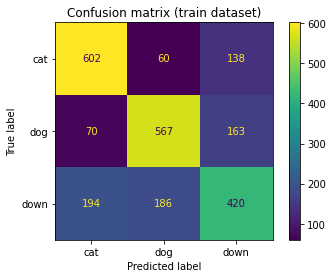

In [123]:
cm = confusion_matrix(yTrain, ypred, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')
plt.show()

Ce ne pas de la triche de regarder les performances sur les données que nous avons utilisées pour construire le classifieur ?

### Evaluation de la classification

Pour évaluer de façon juste, on va utiliser des sons qui n'ont pas déjà servi à l'apprentissage. On va par exemple prendre les nb derniers de chaque classe.

In [124]:
lesMfccTest = np.empty(shape=(nb*len(classes), 13), dtype=float) 
verbose=False

i=0
for cl in classes:
    listSons = glob.glob(basedir+ '\\'+cl+"/*.wav")
    for s in listSons[-nb:]:
        if verbose:
            print("###",s,"###")
        (sig,rate) = librosa.load(s)
        mfcc_feat = librosa.feature.mfcc(sig,rate,n_mfcc=13)
        if verbose:
            print("MFCC: ", mfcc_feat.shape, "len : ", len(sig))
        lesMfccTest[i] = np.mean(mfcc_feat, axis=1)
        i += 1

if verbose:
    print("shape : ",lesMfccTest.shape)
    
xTest = scaler.transform(lesMfccTest)
yTest = []
for clNumber in range(len(classes)):
    yTest += [clNumber]*nb

In [125]:
predTest = logisticRegr.predict(xTest)
print("test F1 score = ", f1_score(yTest, predTest, average = 'micro'))
print("test accuracy score = ", accuracy_score(yTest, predTest))


test F1 score =  0.6758333333333333
test accuracy score =  0.6758333333333333


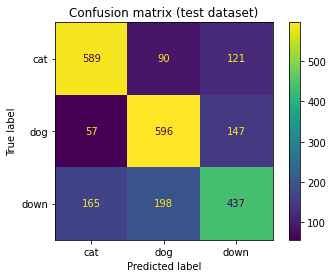

In [126]:
cm = confusion_matrix(yTest, predTest, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (test dataset)')
plt.show()

Essayez d'améliorer les résultats en augmentant le nombre de sons par classes ou en modifiant la représentation des sons.

Essayez également d'autres classes du jeu de données.

In [ ]:
#Tout convertir en wav